In [1]:
from monai import transforms as T
from glob import glob
import os
import numpy as np
import torch
from monai.transforms import LoadImage
from collections import Counter
from monai.data import ITKReader

image_dir = "/cluster/projects/vc/data/mic/open/Prostate/PI-CAI-V2.0/images"
label_dir = "/cluster/projects/vc/data/mic/open/Prostate/PI-CAI-V2.0/picai_labels/csPCa_lesion_delineations/human_expert/resampled"



In [2]:
class ConvertToBinaryLabeld(T.MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key in data:
                label = d[key]  # Extract label tensor
                
                # Convert to binary: 0 for ISUP ≤1, 1 for ISUP ≥2
                d[key] = (label >= 1).float()
                
        return d

In [3]:
patient_folders = sorted(glob(os.path.join(image_dir, "*")))
patient_ids = [os.path.basename(folder) for folder in patient_folders]

empty = np.zeros((1024, 1024, 1024))

data = []
for patient_id in patient_ids:
    
    patient_folder = os.path.join(image_dir, patient_id)
    label_path = glob(os.path.join(label_dir, f"{patient_id}_*.nii.gz"))
    t2w_path = glob(os.path.join(patient_folder, "*_t2w.mha"))
    adc_path = glob(os.path.join(patient_folder, "*_adc.mha"))
    hbv_path = glob(os.path.join(patient_folder, "*_hbv.mha"))

    data_entry = {}
    
    
    if t2w_path and adc_path and hbv_path and label_path:  
        data_entry = {
            "t2w" : t2w_path,
            "adc" : adc_path,
            "hbv" : hbv_path,
            "label" : label_path
            
        }
        
        
 
        data.append(data_entry)
        
    

In [4]:
len(data)

1272

In [5]:
default_preprocess = T.Compose(
                [
                    T.LoadImaged(keys=["t2w", "adc", "hbv", "label"], reader = ITKReader),
                    T.EnsureChannelFirstd(keys=["t2w", "adc", "hbv", "label"]),
            
                    T.ResampleToMatchd(
                        keys=["adc", "hbv"], 
                        key_dst = 't2w',
                        mode="bilinear", 
                        padding_mode="border",  
                        ),
                    
                    T.Orientationd(keys=["t2w", "adc", "hbv", "label"], axcodes="RAS"),
                    
                    T.Spacingd(
                        keys=["t2w", "adc", "hbv", "label"],
                        pixdim=(0.5, 0.5, 1.2),
                        mode=("bilinear", "bilinear", "bilinear", "nearest"),
                    ),
                    
                    T.NormalizeIntensityd(keys=["t2w"], channel_wise=True),
                    T.Resized(keys=["t2w", "adc", "hbv", "label"], spatial_size=[512, 512, 32], mode=("area","area", "area", "nearest")),
                    ConvertToBinaryLabeld(keys=["label"]),
            ]) 

In [6]:
num_samples = 1
augment =  T.Compose(
                [
                    T.RandCropByLabelClassesd(keys=["t2w", "adc", "hbv", "label"], label_key = "label", spatial_size = [256, 256, 32],
                                              num_classes = 2, num_samples = num_samples, ratios = [0.1, 1]),
                    T.RandFlipd(keys=["t2w", "adc", "hbv", "label"], prob=0.5, spatial_axis=0),
                    T.RandFlipd(keys=["t2w", "adc", "hbv", "label"], prob=0.5, spatial_axis=1),
                    T.RandFlipd(keys=["t2w", "adc", "hbv", "label"], prob=0.5, spatial_axis=2),
                ]
            )

In [7]:
transform=T.Compose([default_preprocess, augment])

In [8]:
final_data = transform(data[0:10])


no available indices of class 1 to crop, setting the crop ratio of this class to zero.


In [9]:
loader = T.LoadImaged(keys=["t2w", "adc", "hbv", "label"], reader = ITKReader)
loaded_data = [loader(d) for d in data[:10]]  

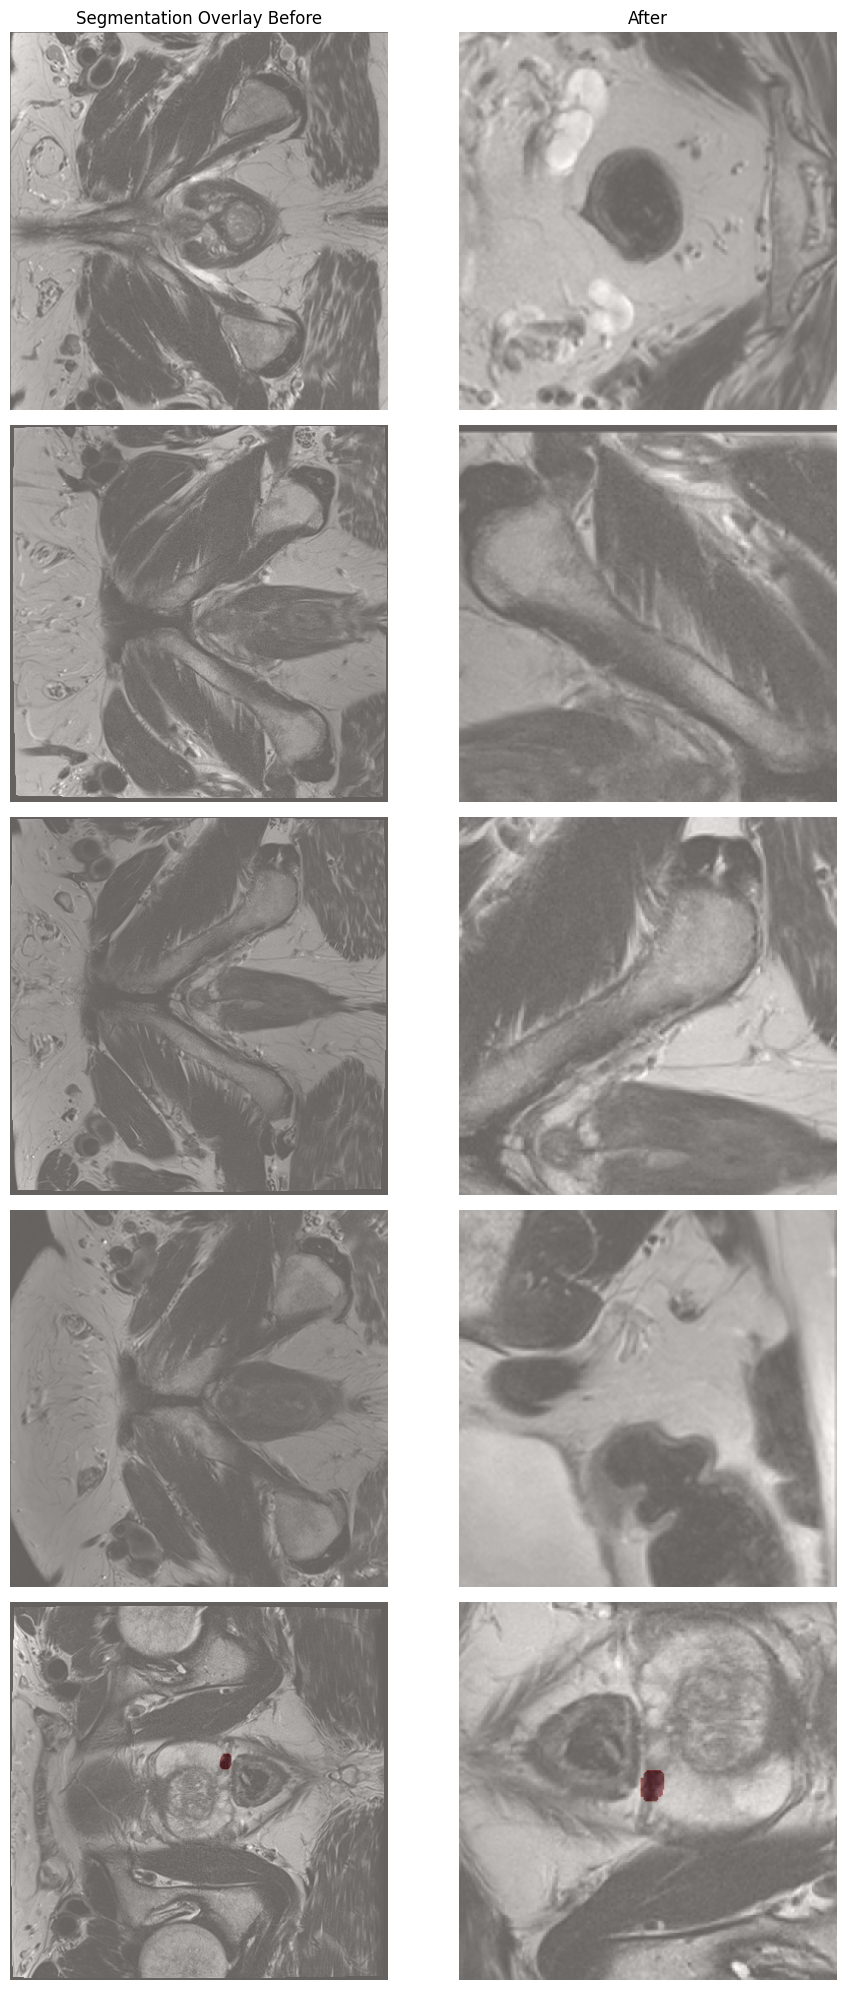

In [10]:
import matplotlib.pyplot as plt

n = 5

fig, axes = plt.subplots(n, num_samples + 1, figsize=(10,20))

axes[0,0].set_title("Segmentation Overlay Before")
axes[0,1].set_title("After")

for i in range(n):
    
    sample = loaded_data[i]
    
    label_slices = np.sum(sample["label"], axis=(0, 1))  
    slice = np.argmax(label_slices)  
    
    
    axes[i, 0].imshow(sample['t2w'][:, :, slice], cmap="gray")  
    axes[i, 0].imshow(sample["label"][:, :, slice], cmap="Reds", alpha=0.4)  
    axes[i, 0].axis("off")
 
    for j in range(num_samples):  # Loop over augmented versions
        
        label_slices_final = np.sum(final_data[i][j]["label"][0], axis=(0, 1))
        slice_final = np.argmax(label_slices_final)
        
        axes[i, j + 1].imshow(final_data[i][j]['t2w'][0, :, :, slice_final], cmap="gray")
        axes[i, j + 1].imshow(final_data[i][j]["label"][0, :, :, slice_final], cmap="Reds", alpha=0.4)
        axes[i, j + 1].axis("off")

    
plt.tight_layout()
plt.show()